# Unsupervised 3D Seismic Data Reconstruction Based On Deep Prior

[Fantong Kong](mailto:kft_upc@hotmail.com)<sup>1</sup>,
[Francesco Picetti](mailto:francesco.picetti@polimi.it)<sup>2</sup>,
Vincenzo Lipari<sup>2</sup>, Paolo Bestagini<sup>2</sup>,
Xiaoming Tang<sup>1</sup>, and Stefano Tubaro<sup>2</sup>

1: School of Geosciences - China University of Petroleum (East), Qingdao, China<br>
2: Dipartimento di Elettronica, Informazione e Bioingegneria - Politecnico di Milano, Italy


In this notebook we show our 3D MultiRes UNet workflow for irregular data interpolation on a synthetic 3D dataset that shows simple hyperbolas.

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import os
import torch
import numpy as np
from argparse import Namespace
from termcolor import colored

from main import Interpolator
import utils as u
from data import extract_patches

import matplotlib.pyplot as plt
from matplotlib import rcParams
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
rcParams.update(params)

### Parameters

In [2]:
args = Namespace(
    gpu=0,
    # problem data
    imgdir = './datasets/hyperbolic3d',
    outdir = './results/',
    imgname = 'original.npy',
    maskname = 'random66_shot1.npy',
    gain = 40.,
    datadim = '3d',
    slice=None,
    imgchannel=1,
    patch_shape=[256,-1,-1],
    patch_stride=[128,-1,-1],
    # architecture
    net = "multiunet",
    activation='LeakyReLU',
    last_activation=None,
    dropout=0.,
    filters=[16, 32, 64, 128, 256],
    skip=[16, 32, 64, 128],
    inputdepth=64,
    noise_dist='n',
    noise_std=.1,
    upsample='trilinear',
    inittype='xavier',
    initgain=0.02,
    filter_noise_with_wavelet=False,
    lowpass_fs=None,
    lowpass_fc=None,
    # optimization and schedulers
    loss="mae",
    epochs=3000,
    lr=1e-3,
    data_forgetting_factor=0,
    start_from_prev=False,
    pocs_weight=None,
    reduce_lr=False,
    lr_factor=0.9,
    lr_thresh=1e-5,
    lr_patience=100,
    savemodel=False,
    save_every=10000,
    loss_max=30.,
    param_noise=False,
    reg_noise_std=0.03,
    adirandel=0,
    earlystop_patience=10000,
    earlystop_min_delta=1.,
)

## Inverse Problem

The Training class is the actual optimization problem

\begin{equation}
    \theta^* = \arg \min_\theta \Vert \mathbf{S} f_\theta(\mathbf{z}) - \mathbf{d}_\text{obs}\Vert_1,
\end{equation}

where $\mathbf{S}$ is the sampling operator we want to invert,
$\mathbf{d}_\text{obs}$ are the acquired coarse and/or irregular data,
$\mathbf{z}$ is a noise tensor that is input of the network,
$f$ is the CNN and $\theta$ its parameters.

The interpolated data are the output of the optimized network: $\mathbf{m}^* = f_{\theta^*}(\mathbf{z})$.


In [3]:
# set the engine to be used
u.set_gpu(args.gpu)
u.set_seed()

GPU selected: 0 - Tesla V100-PCIE-16GB


In [4]:
# create output folder
dir_list = list(filter(None, args.imgdir.split('/')))
outpath = os.path.join(args.outdir, 'notebook')
os.makedirs(outpath, exist_ok=True)
print(colored('Saving to %s' % outpath, 'yellow'))

Saving to ./results/notebook


In [5]:
T = Interpolator(args, outpath)

### Load data

We subdivide the dataset in 3D patches in order to keep the GPU memory usage low.

In [6]:
patches_list = extract_patches(args)

In [7]:
patch = patches_list[0]
t = 64  # time index
x = 64  # receiver index
y = 64  # shot index

opt = dict(cmap="seismic", clim=u.clim(patch["image"], 98))

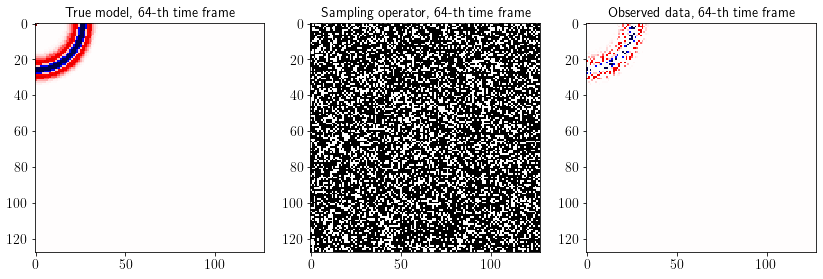

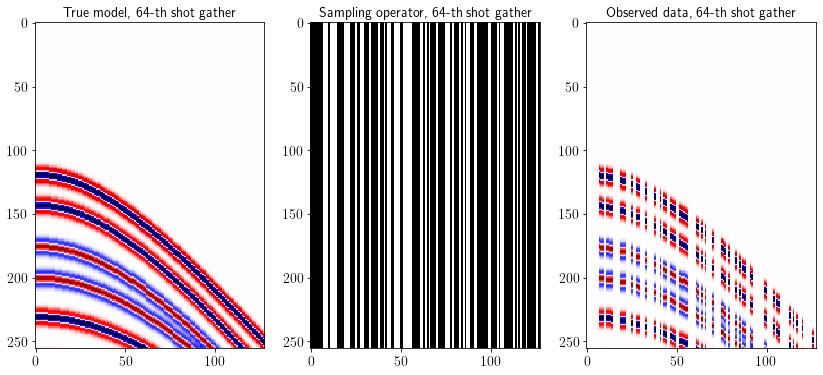

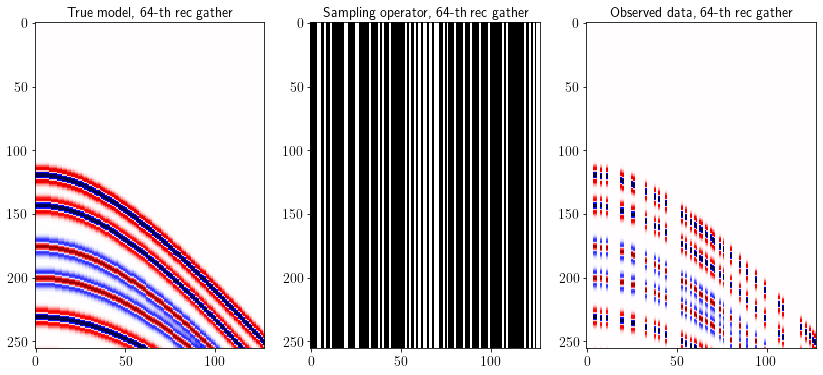

In [8]:


plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th time frame' % t)
plt.imshow(patch['image'][t].squeeze(), **opt)
plt.subplot(132), plt.title('Sampling operator, %i-th time frame' % t)
plt.imshow(patch['mask'][t].squeeze())
plt.subplot(133), plt.title('Observed data, %i-th time frame' % t)
plt.imshow((patch['image'][t]*patch['mask'][t]).squeeze(), **opt)
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th  shot gather' % y)
plt.imshow(patch['image'][:,y].squeeze(), aspect='auto', **opt)
plt.subplot(132), plt.title('Sampling operator, %i-th shot gather' % y)
plt.imshow(patch['mask'][:,y].squeeze(), aspect='auto')
plt.subplot(133), plt.title('Observed data, %i-th  shot gather' % y)
plt.imshow((patch['image'][:,y]*patch['mask'][:,y]).squeeze(), aspect='auto', **opt)
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th rec gather' % x)
plt.imshow(patch['image'][:,:,x].squeeze(), aspect='auto', **opt)
plt.subplot(132), plt.title('Sampling operator, %i-th rec gather' % x)
plt.imshow(patch['mask'][:,:,x].squeeze(), aspect='auto')
plt.subplot(133), plt.title('Observed data, %i-th rec gather' % x)
plt.imshow((patch['image'][:,:,x]*patch['mask'][:,:,x]).squeeze(), aspect='auto', **opt)
plt.show()

### Optimization

In [ ]:
for patch in patches_list:
    
    print(colored('\nThe data shape is %s' % str(patch['image'].shape), 'cyan'))
    
    std = T.load_data(patch)
    print(colored('the std of coarse data is %.2e, ' % std, 'cyan'), end="")

    if np.isclose(std, 0., atol=1e-12):  # all the data are corrupted
        print(colored('skipping...', 'cyan'))
        T.out_best = T.img * T.mask
        T.elapsed = 0.
    else:
        if T.net is None or not args.start_from_prev:
            if args.net == "load":
                T.build_model(netpath=args.netdir[i])
            else:
                T.build_model()
        T.build_input()
        T.optimize()
        
    T.save_result()
    T.clean()

print(colored('Interpolation done!', 'yellow'))


The data shape is (256, 128, 128, 1)
the std of coarse data is 3.94e+00, parameters initialized with xavier
The input shape is (1, 64, 256, 128, 128)
starting optimization with ADAM...
1h:52m:19ss = +4.84e-02, SNR = +16.69 dB, PCORR = +98.93 % 
Finished patch 0

The data shape is (256, 128, 128, 1)
the std of coarse data is 5.16e+00, parameters initialized with xavier
The input shape is (1, 64, 256, 128, 128)
starting optimization with ADAM...


## Results Evaluation

In [9]:
run = np.load(os.path.join(outpath, '0_run.npy'), allow_pickle=True).item()

In [10]:
run.keys()

dict_keys(['device', 'elapsed', 'outpath', 'history', 'mask', 'image', 'output', 'noise'])

In [11]:
output = run['output']

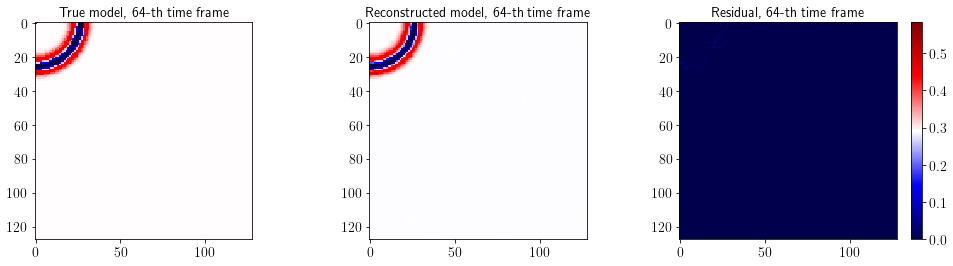

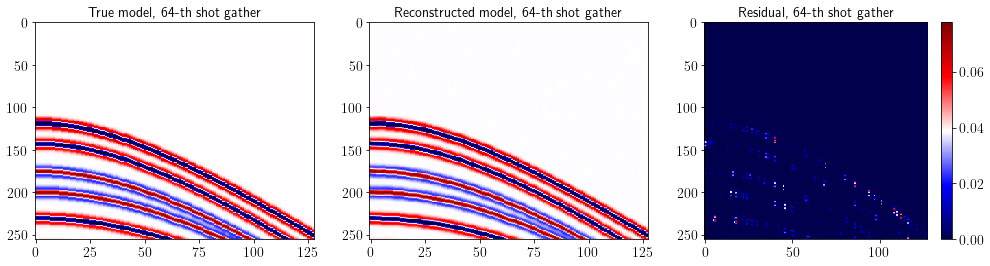

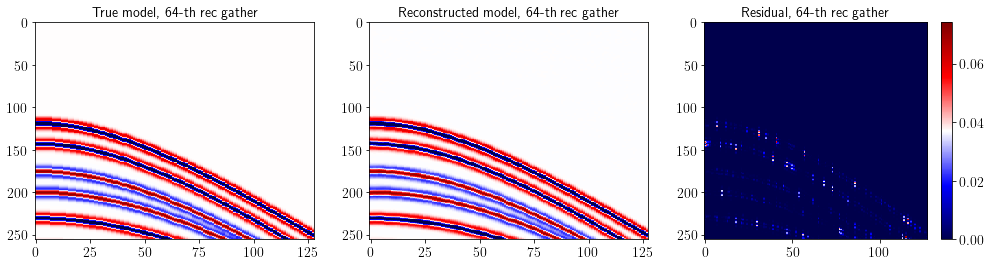

In [15]:
patch = patches_list[0]
t = 64  # time index
x = 64  # receiver index
y = 64  # shot index

normalized_squared_error = (patch['image'].squeeze() - output)**2 / np.max(np.abs(patch['image']))**2

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th time frame' % t)
plt.imshow(patch['image'][t].squeeze(), **opt)
plt.subplot(132), plt.title('Reconstructed model, %i-th time frame' % t)
plt.imshow(output[t].squeeze(), **opt)
plt.subplot(133), plt.title('Residual, %i-th time frame' % t)
plt.imshow(normalized_squared_error[t].squeeze(), cmap='seismic'), plt.colorbar()
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th shot gather' % y)
plt.imshow(patch['image'][:,y].squeeze(), aspect='auto', **opt)
plt.subplot(132), plt.title('Reconstructed model, %i-th shot gather' % y)
plt.imshow(output[:,y].squeeze(), aspect='auto', **opt)
plt.subplot(133), plt.title('Residual, %i-th shot gather' % y)
plt.imshow(normalized_squared_error[:,y].squeeze(), cmap='seismic', aspect='auto'), plt.colorbar()
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th rec gather' % x)
plt.imshow(patch['image'][:,:,x].squeeze(), aspect='auto', **opt)
plt.subplot(132), plt.title('Reconstructed model, %i-th rec gather' % x)
plt.imshow(output[:,:,x].squeeze(), aspect='auto', **opt)
plt.subplot(133), plt.title('Residual, %i-th rec gather' % x)
plt.imshow(normalized_squared_error[:,:,x].squeeze(), cmap='seismic', aspect='auto'), plt.colorbar()
plt.show()

### Check optimization objective function

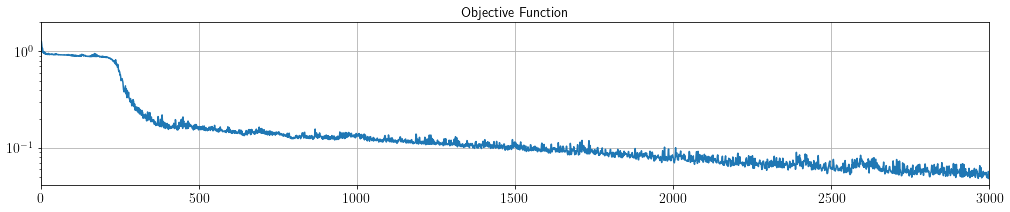

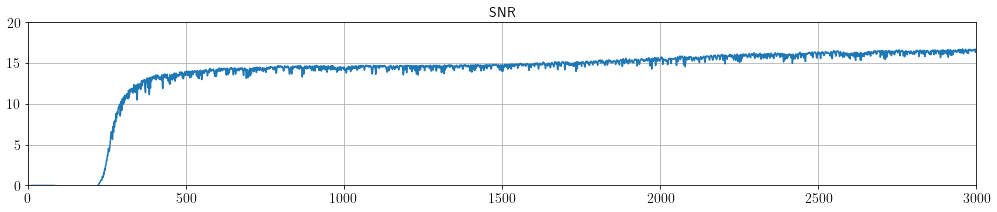

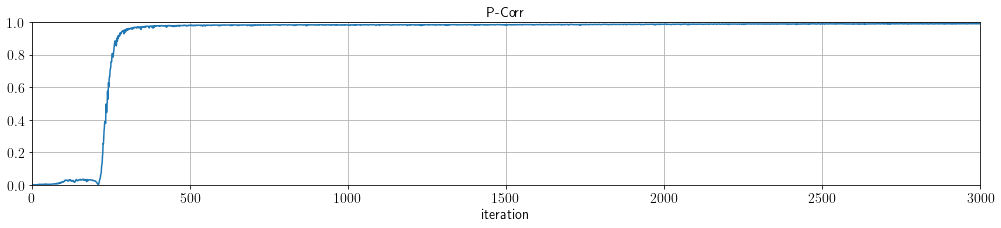

In [25]:
plt.figure(figsize=(17,3))
plt.title('Objective Function')
plt.semilogy(run['history'].loss)
plt.grid(True), plt.xlim(0, args.epochs), plt.ylim(0, 2)

plt.figure(figsize=(17,3))
plt.title('SNR')
plt.plot(run['history'].snr)
plt.grid(True), plt.xlim(0, args.epochs), plt.ylim(0,20)

plt.figure(figsize=(17,3))
plt.title('P-Corr')
plt.plot(np.abs(run['history'].pcorr))
plt.grid(True), plt.xlabel('iteration'), plt.xlim(0, args.epochs), plt.ylim(0, 1)
plt.show()